# Data Processing v2 for full cohort

In [1]:
import sys
sys.path.append("..")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, OneHotEncoder

from src.tests import validate_dataset, assert_group_identical
from src.data_processing import plot_df_histogram, remove_outliers, any_one, forward_back_fill, \
                                case_aggregation, convert_inconsistent_uom, \
                                plot_cohort_statistics, plot_df_histogram, \
                                calculate_feature_correlation

## Import initial_cohort

In [2]:
df = pd.read_csv("../data/full_cohort_final_v02.csv", index_col=0)
cohort_size = len(df)
cohort_size

53461

## One Hot Encode

Standard one-hot encode:  
- admission_type
- ventilation_status

One-hot encode but will result in multicolinear, thus use drop first option:  
- gender

In [3]:
# Standard one-hot encode
df = pd.get_dummies(data=df, columns=["admission_type", "ventilation_status"])

# One-hot encode while eliminating multicolinearity
df = pd.get_dummies(data=df, columns=["gender"], drop_first=True)

## Clean column names

Oddities in column names can occur from one-hot encoding. Remove spaces from column names by replacing them with underscore and remove additional special characters.

In [4]:
# Replace spaces in column names with underscore
df.columns = df.columns.str.replace(" ", "_")
# Remove any other characters from the column names
df.columns = df.columns.str.replace(".", "")
# Convert names to lowercase
df.columns = df.columns.str.lower()
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'n_stays', 'sum_los', 'anchor_age',
       'suspected_infection', 'weight', 'height_chart', 'heart_rate_min',
       'heart_rate_max', 'temperature_min', 'temperature_max', 'abpm_min',
       'abpm_max', 'abpd_min', 'abpd_max', 'abps_min', 'abps_max', 'nbpm_min',
       'nbpm_max', 'nbpd_min', 'nbpd_max', 'nbps_min', 'nbps_max', 'rr_min',
       'rr_max', 'spo2_min', 'spo2_max', 'albumin_min', 'albumin_max',
       'platelet_min', 'platelet_max', 'bun_min', 'bun_max', 'calcium_min',
       'calcium_max', 'creatinine_min', 'creatinine_max', 'glucose_min',
       'glucose_max', 'bicarbonate_min', 'bicarbonate_max', 'potassium_min',
       'potassium_max', 'sodium_min', 'sodium_max', 'bilirubin_min',
       'bilirubin_max', 'wbc_min', 'wbc_max', 'lactate_min', 'lactate_max',
       'magnesium_min', 'magnesium_max', 'ph_min', 'ph_max', 'pco2_min',
       'pco2_max', 'po2_min', 'po2_max', 'gcs_min', 'sofa', 'urineoutput',
       'dopamine_amount', 

## Handle ventilation_status

Propagate one-hot coded ventilation_status features across rows grouped by 
subject_id, hadm_id, as there are many rows each with one ventilation_status 
type.  

**These rows will need to be merged/flattened later.**

In [5]:
df = df.groupby(["subject_id", "hadm_id"]) \
    .apply(any_one, startswith="ventilation_status")

## Transform binary encode interventions

Certain interventions such as vasoactive drugs and some laboratory tests are very sparesely performed. (Check the EDA for threshold and feature identification).  

These features are transformed by binary encoding them into `[1-given, 0-not-given]` rather than using their absolute values. 

In [6]:
va_drugs = ["dopamine", "epinephrine", "norepinephrine", "phenylephrine",
            "vasopressin", "dobutamine", "milrinone"]

lab_tests = ["albumin", "bilirubin", "abps", "abpd", "abpm"]

diagnostic_states = ["suspected_infection"]

interventions = va_drugs + lab_tests + diagnostic_states

for intervention in interventions:
    # Get all columns starting with intervention
    cols = df.columns.str.startswith(intervention)
    # If any of the intervention columns register a non-NA value, accept as 1-given
    df[intervention] = \
        np.where(df.loc[:, cols].notna().any(axis=1), 1, 0)
    # Clean up and drop the original intervention columns if necessary
    if len(cols) < len(df.columns):
        df = df.loc[:, ~ np.append(cols, False)]

df[interventions].head(10)

,dopamine,epinephrine,norepinephrine,phenylephrine,vasopressin,dobutamine,milrinone,albumin,bilirubin,abps,abpd,abpm,suspected_infection
0,0,0,1,0,0,0,0,1,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,1,1,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,1,1,1,1,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,1,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0


Similar to ventilation_status, we will need to propagate the interventions status across rows within subject admission groups.

In [7]:
for intervention in interventions:
    df = df.groupby(["subject_id", "hadm_id"]) \
    .apply(any_one, startswith=intervention)

## "Forward-back" fill strategy for missing values

If there are any missing values within any ICU stay but values exist in other ICU stays within the same admission, the "forward-back" fill strategy is used whereby:

1. Firstly carry forward all valid values, then  
2. For any remaining missing values, fill backwards (for missing values at the beginning of admission).  



In [8]:
df = df.groupby(["subject_id", "hadm_id"]).apply(forward_back_fill)

## Check for any further missing values

In [9]:
missing_threshold = 0
missing_values = pd.DataFrame(df.isna().sum(), columns=["NA_count"])
missing_values.index.name = "feature"
missing_values["NA_proportion"] = missing_values["NA_count"] / cohort_size
missing_values = missing_values[missing_values["NA_proportion"] > missing_threshold] \
    .sort_values(by=["NA_proportion"], ascending=False)
missing_values

,NA_count,NA_proportion
feature,,
height_chart,23186,0.433699
po2_max,17810,0.333140
po2_min,17810,0.333140
pco2_min,17810,0.333140
pco2_max,17810,0.333140
ph_min,16616,0.310806
ph_max,16616,0.310806
lactate_max,11839,0.221451
lactate_min,11839,0.221451


# Remove instances with missing data

In [10]:
df = df.dropna(axis=0, how="any")
len(df)

14693

## Handling of specific features across different ICU stays

Aggregate values across multiple ICU stays grouped by the same admission.

| Feature          | Handling method |
| ---------------- | --------------- |
| Ending with _min | min             |
| Ending with _max | max             |
| sofa             | max             |
| urineoutput      | min             |
| weight           | min             |
| height_chart     | mean            |

In [11]:
df = df.groupby(["subject_id", "hadm_id"]).apply(case_aggregation, cases=[
    ("_min", np.min),
    ("_max", np.min),
    ("sofa", np.max),
    ("urineoutput", np.min),
    ("weight", np.min),
    ("height_chart", np.mean)
])
len(df)

14693

## Merge/flatten

Flatten each group of subject_id and hadm_id to one row, first checking that each group has identical rows.

In [12]:
try:
    # Check all groups have identical rows
    df.groupby(["subject_id", "hadm_id"]).apply(assert_group_identical)
    
    # Flatten the groups to one row per group
    df = df.groupby(["subject_id", "hadm_id"]).first().reset_index()
    
    print(len(df))
except AssertionError as msg:
    print(msg)

9702


## Handle outliers

### Statistical outliers

We are not going to remove statistical outliers, instead handle them with RobustScaler.  

### Non-physiologic outliers

Defined as measurements outside of physiological possibility that may indicate measurement error.  

#### Inconsistent unit of measurement

- Temperature less than 53 are assumed to be in celcius and converted to fahrenheit
- Height less than 72 are assumed to be in inches and converted to cm

In [13]:
df = convert_inconsistent_uom(df)

#### Abnormal readings

The following abnormal readings are pruned from the dataset.

In [14]:
df = df.loc[(
    (df["weight"] >= 20) & (df["weight"] <= 500) &
    (df["height_chart"] >= 50) & (df["height_chart"] <= 260) &
    (df["temperature_min"] >= 53) & (df["temperature_max"] <= 176) &
    (df["heart_rate_max"] <= 300) &
    (df["nbps_max"] <= 350) &
    (df["nbpd_max"] <= df["nbps_max"]) & (df["nbpd_min"] <= df["nbps_min"]) &
    (df["nbpm_max"] <= df["nbps_max"]) & (df["nbpm_min"] >= df["nbpd_min"]) &
    (df["spo2_max"] <= 100) &
    (df["rr_max"] <= 120) &
    (df["ph_min"] >= 6)
)]
len(df)

9480

## Glimpse and validate

In [15]:
df.head(10)

,subject_id,hadm_id,stay_id,n_stays,sum_los,anchor_age,suspected_infection,weight,height_chart,heart_rate_min,...,norepinephrine,phenylephrine,vasopressin,dobutamine,milrinone,albumin,bilirubin,abps,abpd,abpm
0,10002428,20321825,34807493,1,2.023843,80,1,55.00,150.0,82.0,...,0,0,0,0,0,0,1,0,0,0
1,10002428,28662225,33987268,2,12.014028,80,1,43.00,150.0,93.0,...,1,1,0,0,0,0,1,1,1,1
2,10002443,21329021,35044219,1,2.750729,53,0,156.10,178.0,73.0,...,0,0,0,0,0,1,1,0,0,0
3,10004422,21255400,32155744,1,6.356898,78,1,66.95,175.0,59.0,...,0,1,0,0,0,0,0,1,1,1
4,10004606,29242151,30213599,1,5.166100,64,0,55.05,163.0,79.0,...,0,0,0,0,0,0,1,1,1,1
5,10004733,27411876,39635619,1,8.357373,51,1,111.65,180.0,82.0,...,0,0,0,0,0,0,0,0,0,0
6,10004764,24817563,32104791,1,2.489248,70,1,69.85,170.0,77.0,...,0,1,0,0,0,0,0,1,1,1
7,10005606,29646384,38740124,1,6.595347,38,1,84.10,178.0,83.0,...,0,0,0,0,0,1,1,1,1,1
8,10006131,27849136,30177745,1,1.728912,45,0,78.80,170.0,68.0,...,0,0,0,0,0,1,1,0,0,0
9,10006633,25978757,32905915,1,1.080764,66,0,94.90,173.0,84.0,...,0,1,0,0,0,0,0,1,1,1


In [16]:
validate_dataset(df)

INFO:root:Dataset is valid


True

## Handle multicollinearity

### Check for multicollinearity

Check pearson correlation coefficients across the features.

In [17]:
df_corr = calculate_feature_correlation(
    df.drop(columns=["subject_id", "hadm_id", "stay_id", "sum_los"])
)
df_corr.to_csv("../data/cohort_feature_correlation_full_cohort.csv")
df_corr.loc[(df_corr["pearson_abs"] >= 0.5)]

,X1,X2,pearson_abs,pearson_dir
5849,abpd,abps,0.999563,1.0
5773,abps,abpd,0.999563,1.0
5774,abps,abpm,0.992806,1.0
5926,abpm,abps,0.992806,1.0
5927,abpm,abpd,0.992365,1.0
...,...,...,...,...
5821,abpd,po2_max,0.506159,1.0
5744,abps,po2_max,0.506098,1.0
3616,po2_max,abps,0.506098,1.0
3618,po2_max,abpm,0.503640,1.0


### Handle multicolinear features

Below highly correlated features are considered safe to drop.

In [18]:
df = df.drop(columns=[
    # Arterial blood pressure (invasive), keep systolic [abps]
    "abpd", "abpm",
    # Non-invasive blood pressure, keep systolic and mean [nbps_*, nbpm_*]
    "nbpd_min", "nbpd_max",
    # Blood urea nitrogen, keep max [bun_max]
    "bun_min",
    # Creatinine, keep max [creatinine_max]
    "creatinine_min",
    # Platelet, keep max [platelet_max]
    "platelet_min",
    # White blood cell count, keep max [wbc_max]
    "wbc_min"
])

### Recheck correlation

In [19]:
df_corr = calculate_feature_correlation(
    df.drop(columns=["subject_id", "hadm_id", "stay_id", "sum_los"])
)
df_corr.loc[(df_corr["pearson_abs"] >= 0.5)]

,X1,X2,pearson_abs,pearson_dir
1749,bicarbonate_max,bicarbonate_min,0.780020,1.0
1681,bicarbonate_min,bicarbonate_max,0.780020,1.0
838,nbps_max,nbpm_max,0.779484,1.0
702,nbpm_max,nbps_max,0.779484,1.0
768,nbps_min,nbpm_min,0.778465,1.0
632,nbpm_min,nbps_min,0.778465,1.0
2029,sodium_max,sodium_min,0.751551,1.0
1961,sodium_min,sodium_max,0.751551,1.0
1467,creatinine_max,bun_max,0.739782,1.0
1263,bun_max,creatinine_max,0.739782,1.0


## Save processed dataset

In [20]:
# Save copy of processed dataset
df = df.reset_index(drop=True)
df.index.name = "ID"
df.to_csv("../data/cohort_processed_v2_full_cohort.csv")

# Drop identifiers and save feature set and label set separately
df = df.drop(columns=["subject_id", "hadm_id", "stay_id"])
df_labels = df.copy()[["sum_los"]]
# Add additional label where extended LOS is sum_los >= 3.3
df_labels["extended_los"] = np.where(df["sum_los"] >= 3.3, 1, 0)
df_labels.to_csv("../data/cohort_labels_v2_full_cohort.csv")
df_features = df.drop(columns=["sum_los"])
df_features.to_csv("../data/cohort_features_v2_full_cohort.csv")

# Print statistics
print(f"Number of instances {len(df_features)}")
print(f"Number of features {len(df_features.columns)}")

Number of instances 9480
Number of features 69


## RobustScaler

Scale numeric features and handle outliers at the same time using RobustScaler.

In [21]:
# Take a copy of the dataframe features
df_features_scaled = df_features.copy()

# Identify which are the numerical feature columns
numeric_cols = pd.Index(
    df_features_scaled.apply(
        lambda x: not np.array_equiv(
            np.sort(x.unique()), np.array([0, 1])
        )
    )
)

# Apply the RobustScaler
df_features_scaled.loc[:, numeric_cols] = \
    RobustScaler(with_centering=True, with_scaling=True) \
    .fit_transform(df_features_scaled.loc[:, numeric_cols])

# Save the scaled features
df_features_scaled.to_csv("../data/cohort_features_scaled_v2_full_cohort.csv")
df_features_scaled.head(5)

,n_stays,anchor_age,suspected_infection,weight,height_chart,heart_rate_min,heart_rate_max,temperature_min,temperature_max,nbpm_min,...,dopamine,epinephrine,norepinephrine,phenylephrine,vasopressin,dobutamine,milrinone,albumin,bilirubin,abps
ID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.863636,1,-0.977242,-1.333333,0.684211,0.423077,-0.250,0.421053,-1.1250,...,0,0,0,0,0,0,0,0,1,0
1,1.0,0.863636,1,-1.405622,-1.333333,1.263158,0.730769,1.000,1.473684,-1.7500,...,0,0,1,1,0,0,0,0,1,1
2,0.0,-0.363636,0,2.631861,0.533333,0.210526,1.884615,-1.250,0.000000,0.4375,...,0,0,0,0,0,0,0,1,1,0
3,0.0,0.772727,1,-0.550647,0.333333,-0.526316,1.538462,-0.125,-0.210526,-0.4375,...,0,0,0,1,0,0,0,0,0,1
4,0.0,0.136364,0,-0.975457,-0.466667,0.526316,0.576923,2.375,0.842105,0.7500,...,0,0,0,0,0,0,0,0,1,1


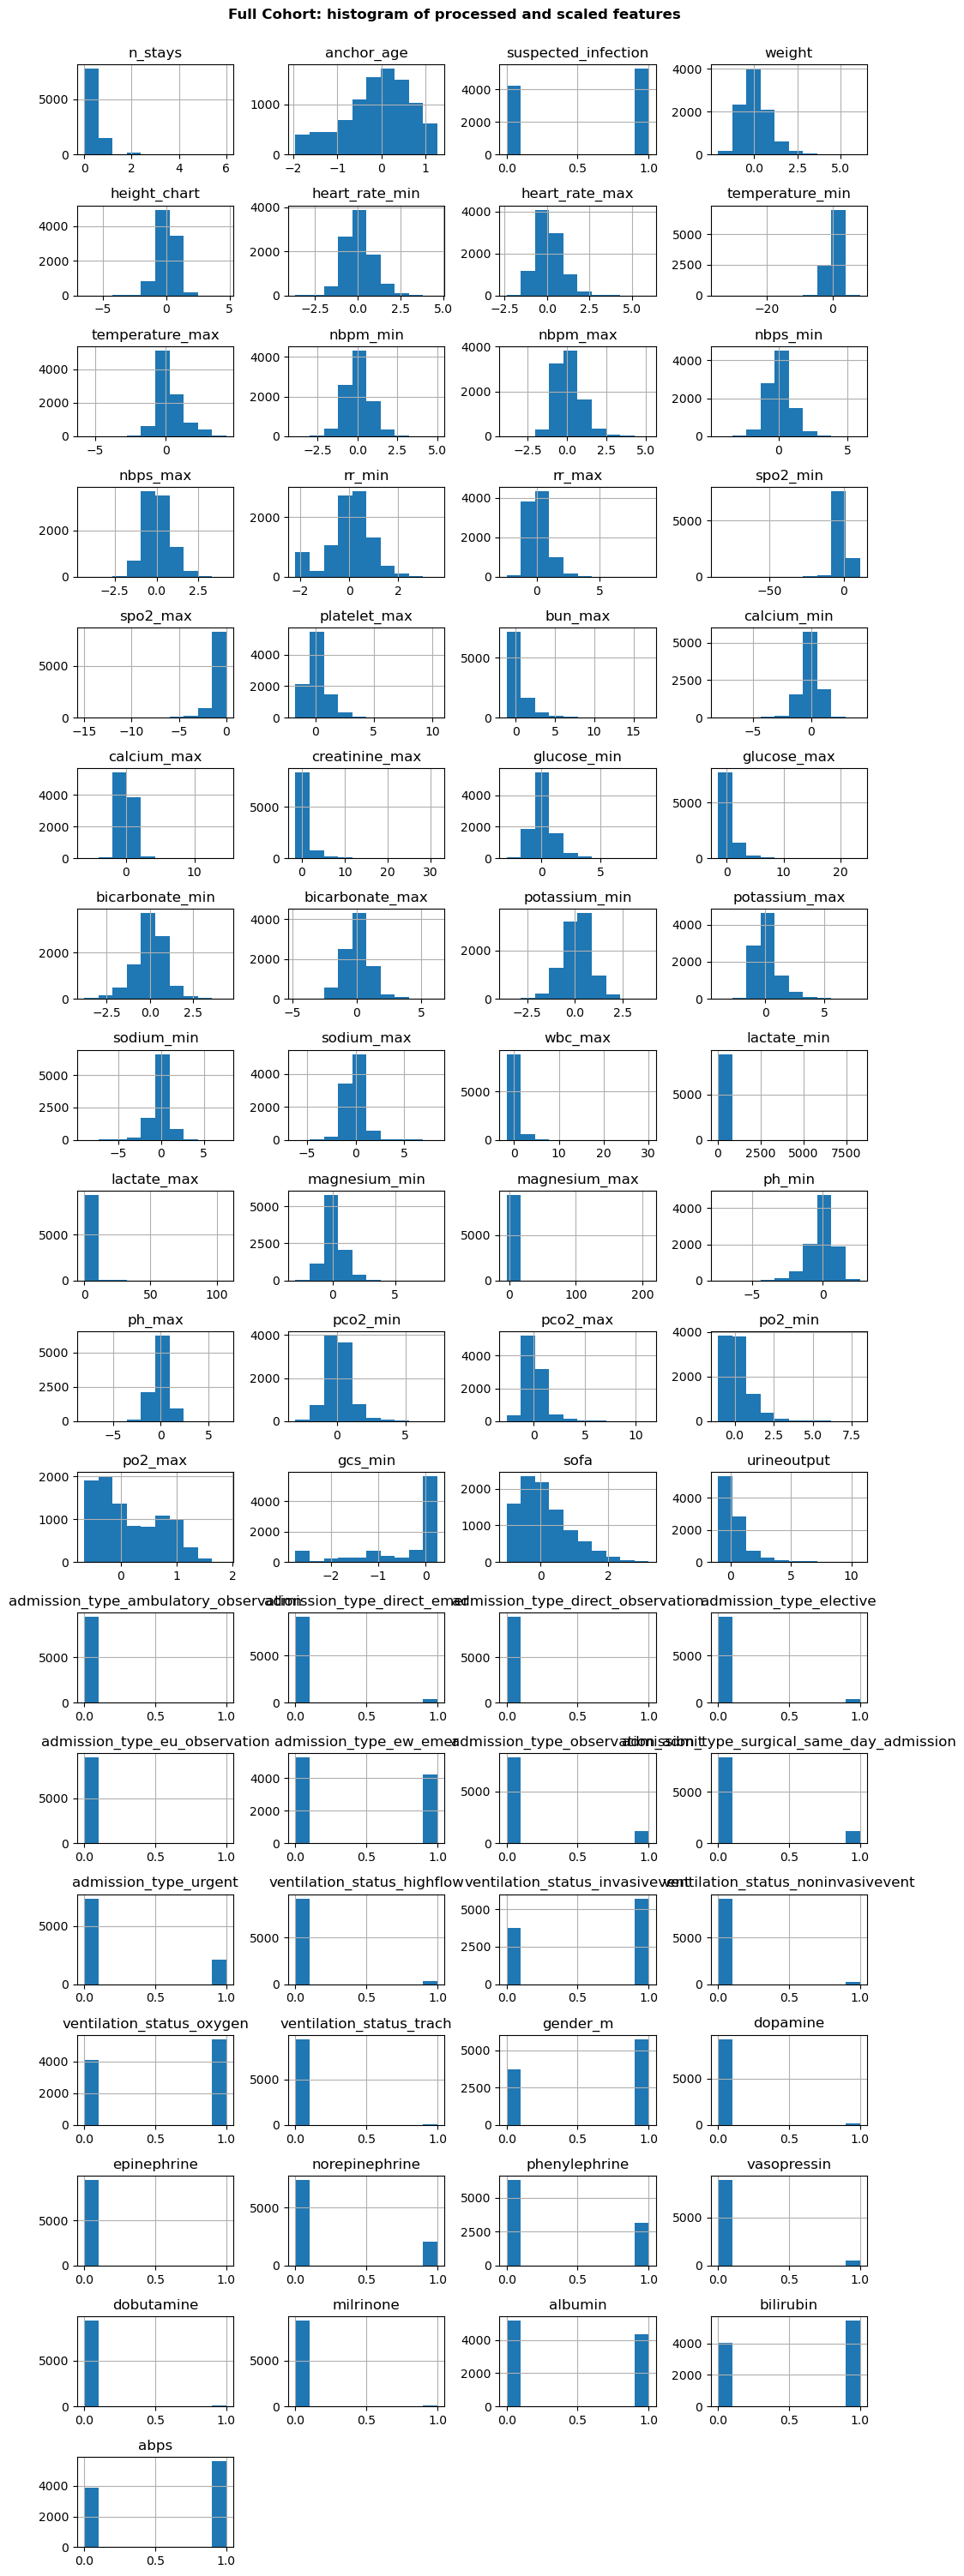

In [22]:
plot_df_histogram(
    df_features_scaled,
    title="Full Cohort: histogram of processed and scaled features",
    figsize=(10, 30),
    across=4
)

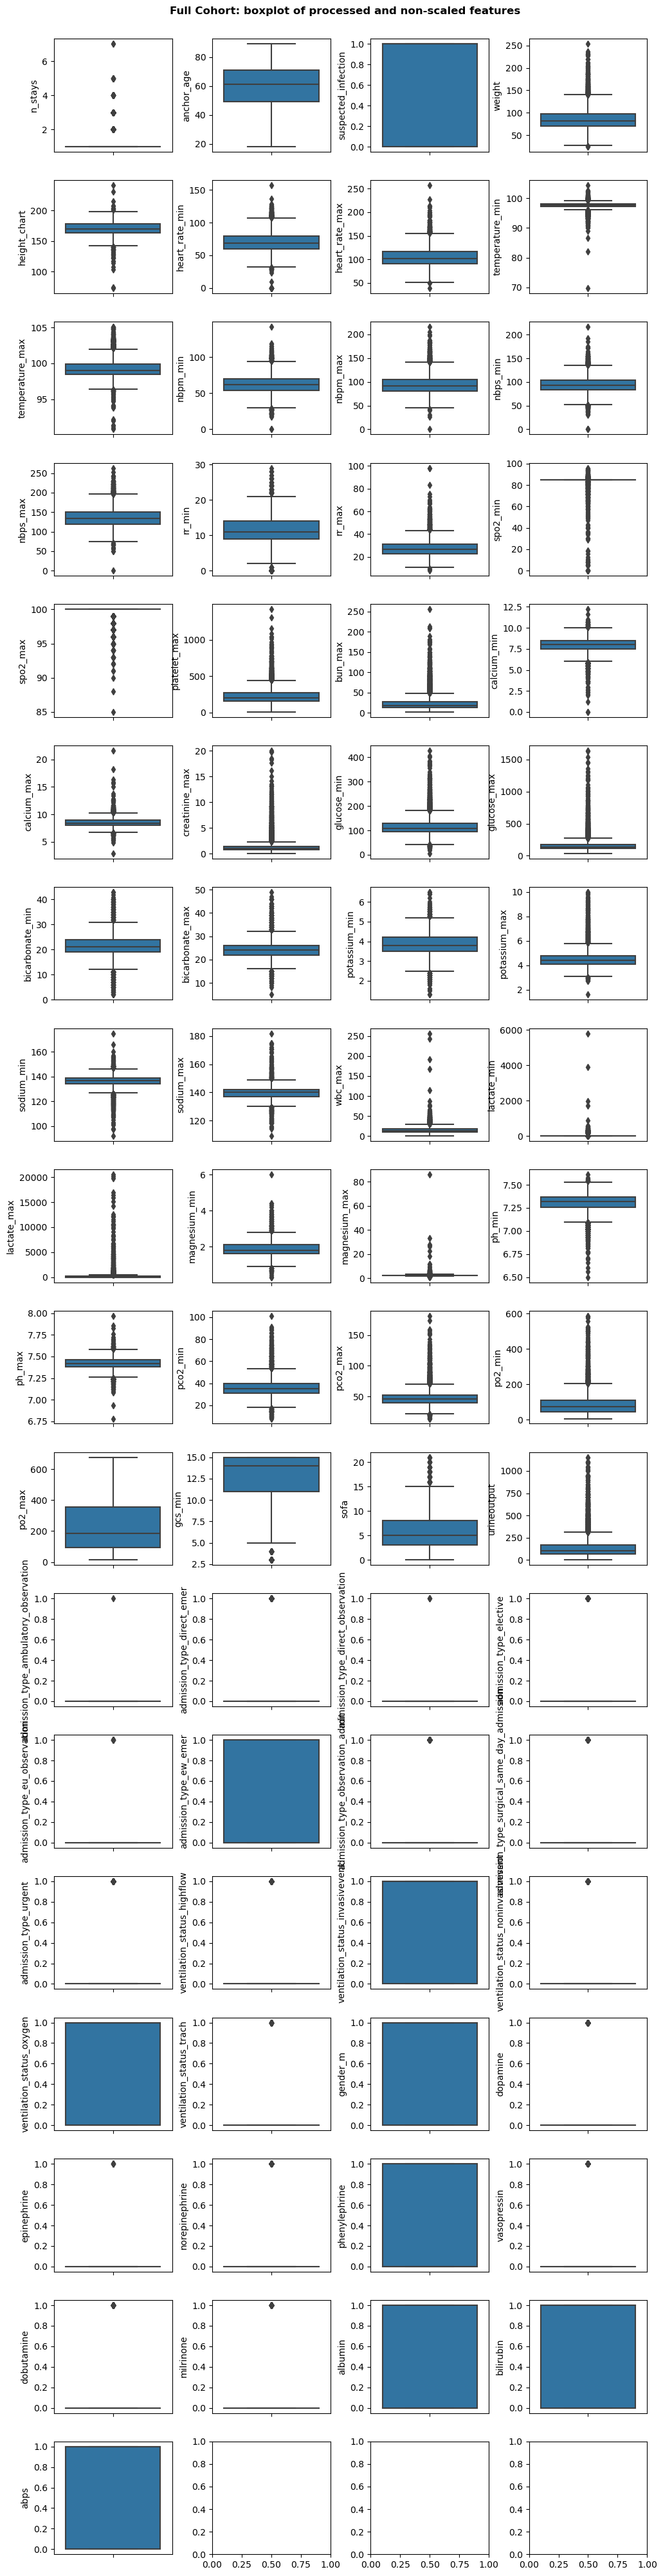

In [23]:
plot_cohort_statistics(
    df_features,
    title="Full Cohort: boxplot of processed and non-scaled features",
    figsize=(10, 40),
    across=4
)

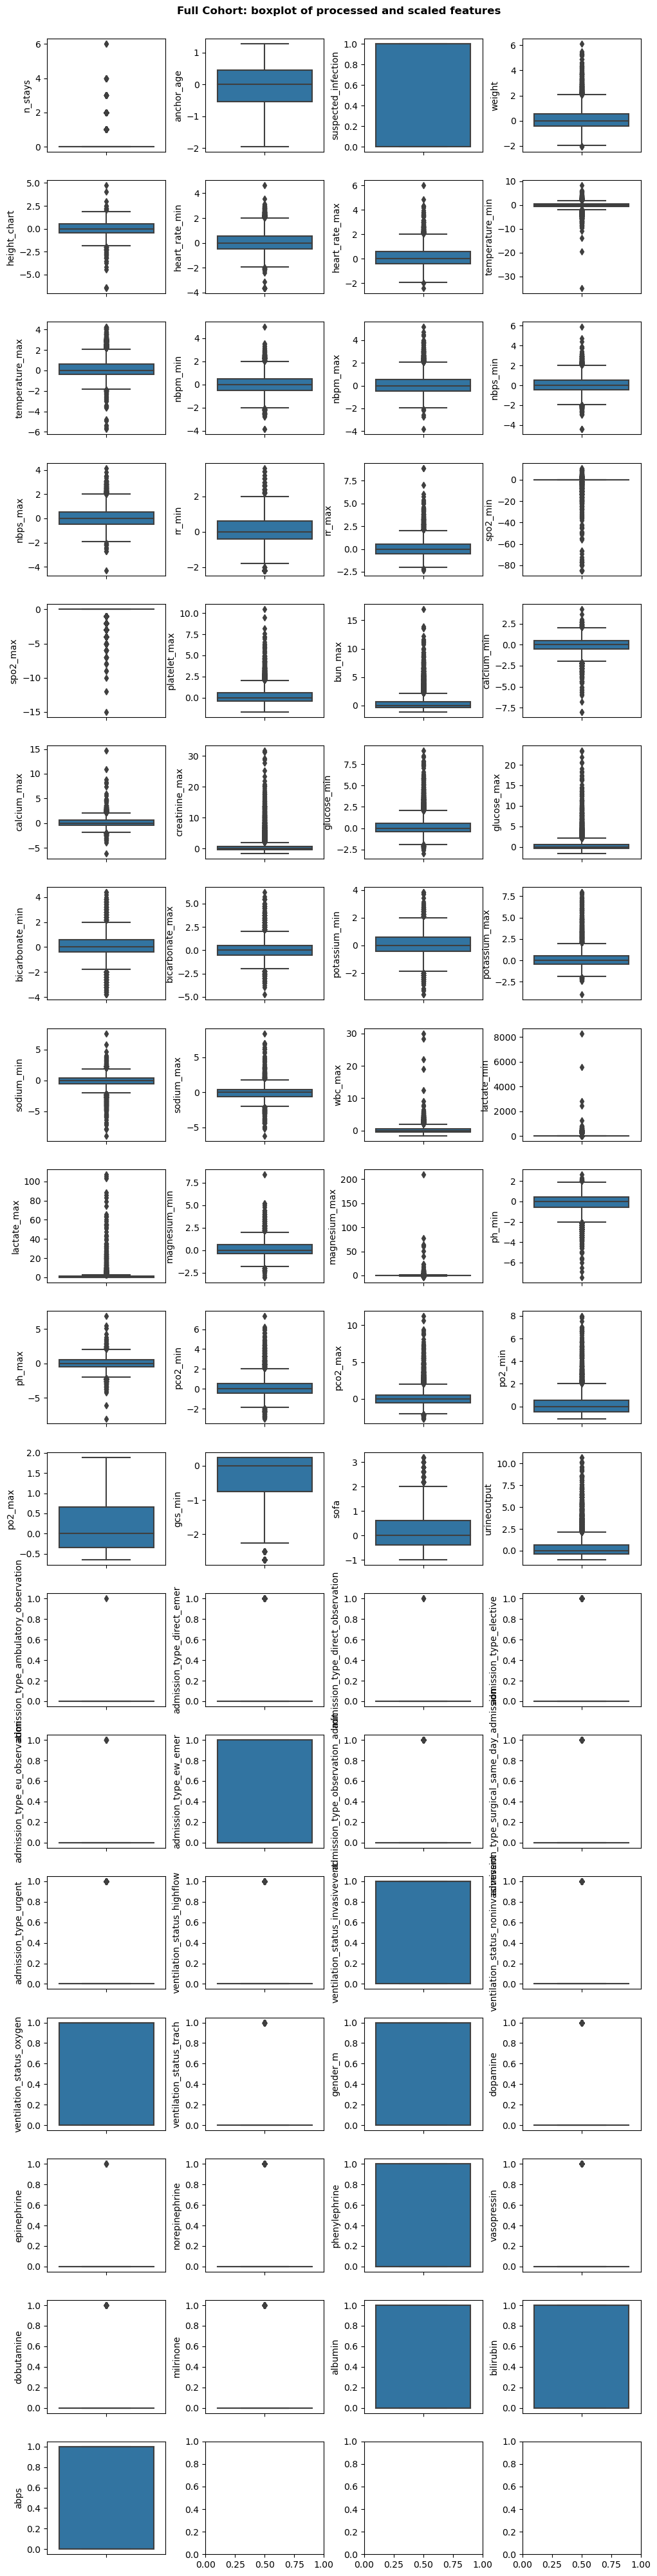

In [24]:
plot_cohort_statistics(
    df_features_scaled,
    title="Full Cohort: boxplot of processed and scaled features",
    figsize=(10, 40),
    across=4
)